In [193]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization.utils import _get_layered_instructions
from ibm_quantum_widgets import *

from qiskit.circuit.library import QFT

from numpy import pi

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-13 11:19:17,536: Credentials are already in use. The existing account in the session will be replaced.


In [194]:
"""Creates a list of sub-circuits of a QuantumCircuit by column"""

'Creates a list of sub-circuits of a QuantumCircuit by column'

In [195]:
# Setup simulators
state_vector_sim = Aer.get_backend('statevector_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

# Define helper functions
def get_state_vector(circuit):
    return state_vector_sim.run(circuit).result().get_statevector()

def get_unitary_matrix(circuit):
    return execute(circuit, unitary_sim).result().get_unitary()

def get_amplitudes(matrix):
    """Can also pass in a state vector"""
    return abs(matrix)

def get_phases(matrix):
    """Can also pass in a state vector"""
    return np.angle(matrix)

# Pretty-printing
def print_matrix(matrix):
    print('Matrix shape ', matrix.shape)
    for row in matrix:
        for num in row:
            print(f"{np.around(num, 2)}   ", end='')
        print('')
    print('\n---')
    
def print_vector(vector):
    print('Vector shape ', vector.shape)
    for num in vector:
        print(np.around(num, 2))
    print('---')

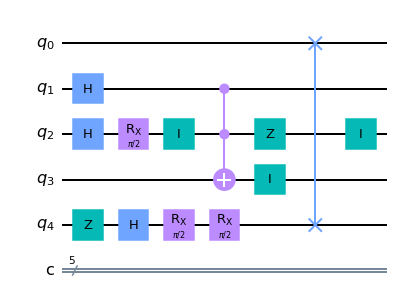

In [208]:
# Place circuit here

#From QASM string
qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

h q[1];
h q[2];
z q[4];
rx(pi/2) q[2];
h q[4];
id q[2];
rx(pi/2) q[4];
ccx q[1],q[2],q[3];
rx(pi/2) q[4];
z q[2];
id q[2];
swap q[0],q[4];
id q[3];
"""
circuit = QuantumCircuit.from_qasm_str(qasm)

#circuit = QFT(4)
circuit.draw()

In [209]:
# Each sub-circuit will have the same number of qubits as the original circuit
num_qubits = circuit.num_qubits
num_clbits = circuit.num_clbits
# We only care about the number of columns from _get_layered_instructions()
_, _, ops = _get_layered_instructions(circuit)
num_columns = len(ops)
print(f'Number of columns: {num_columns}')
print(f'Number of qubits: {num_qubits}')
print(f'Number of clbits: {num_clbits}')

Number of columns: 7
Number of qubits: 5
Number of clbits: 5


In [210]:
# print(f'A preview of circuit.data ({len(circuit.data)} gates total)')
# for i in range(0, 5):
#     print(circuit.data[i])

In [211]:
# Initialize the data structures that hold column information

# A list that keeps track of the column to insert the next gate
# curr_column[qubit.index] = column
curr_column = [0] * num_qubits # creates a list of size num_qubits
print('curr_columns', curr_column)

# A 2-D array that holds the actual instructions by column
# where columns[0] = [(insn, qargs, cargs) tuples] (list of instructions at column 0)
columns = []
for i in range(num_columns):
    columns.append([])
print('columns', columns)

curr_columns [0, 0, 0, 0, 0]
columns [[], [], [], [], [], [], []]


In [212]:
# Obtain the instructions by column
for (insn, qargs, cargs) in circuit.data:    
    # First find the right-most column
    # This will determine the column of all the qubits of this gate
    col = -1
    anchor_qubit = -1 # the qubit with the highest column value
    for qubit in qargs:
        if curr_column[qubit.index] > col:
            col = curr_column[qubit.index]
            anchor_qubit = qubit.index
    if col == -1 or anchor_qubit == -1:
        print('Something went wrong...')
        continue
    
    # At this point "col" contains the rightmost column
    columns[col].append((insn, qargs, cargs))
    # Update the column for this qubit for the next gate in the future
    curr_column[anchor_qubit] += 1
    # All the qubits in this instruction will have the same column value
    # for the next gate in the future
    for qubit in qargs:
        curr_column[qubit.index] = curr_column[anchor_qubit]

print(f'By column ({num_columns} columns total)')
for col in range(0, num_columns):
    print(f'Column {col}: {len(columns[col])} gates')
    for (insn, qargs, cargs) in columns[col]:
        print(insn)
        print(qargs)
    print('---')

By column (7 columns total)
Column 0: 3 gates
[Qubit(QuantumRegister(5, 'q'), 1)]
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 1: 2 gates
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 2: 2 gates
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 3: 2 gates
[Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 4: 3 gates
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 3)]
[Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 5: 1 gates
[Qubit(QuantumRegister(5, 'q'), 2)]
---
Column 6: 0 gates
---


<ipython-input-212-3feec4ff8ddc>:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if curr_column[qubit.index] > col:
<ipython-input-212-3feec4ff8ddc>:9: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  col = curr_column[qubit.index]
<ipython-input-212-3feec4ff8ddc>:10: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  anchor_qubit = qubit.index
<ipython-input-212-3feec4ff8ddc>:22: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  curr_column[qubit.index] = curr_column[anchor_qubit]


In [213]:
# Build the subcircuits by column
sub_circuits = []
for col in range(0, num_columns):
    sub_circuit = QuantumCircuit(num_qubits, num_clbits)
    for (insn, qargs, cargs) in columns[col]:
        sub_circuit.append(insn, qargs, cargs)
    sub_circuits.append(sub_circuit)

assert len(sub_circuits) == num_columns

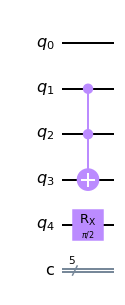

In [214]:
sub_circuits[3].draw()

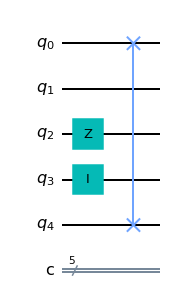

In [215]:
sub_circuits[4].draw()

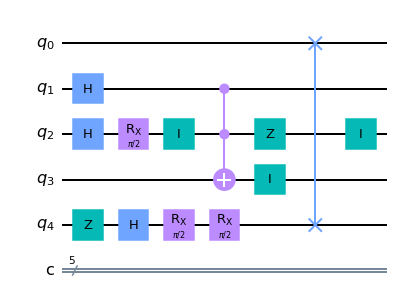

In [216]:
# Check if the combined circuit looks like the original
combined_circuit = sub_circuits[0]
for i in range(1, len(sub_circuits)):
    # https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.compose
    combined_circuit = combined_circuit.compose(sub_circuits[i])
    # combined_circuit += sub_circuits[i]

# Print combined circuit
combined_circuit.draw()

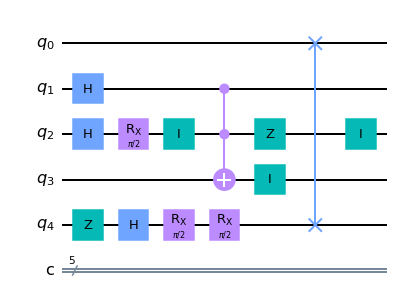

In [217]:
# Print original
circuit.draw()

In [218]:
# Correct way to compare two circuits is by state-vector?
# https://quantumcomputing.stackexchange.com/questions/13723/test-equivalence-of-circuits-exactly-on-qiskit
from qiskit.quantum_info import Statevector
print('Statevector compare: ', Statevector.from_instruction(circuit).equiv(Statevector.from_instruction(combined_circuit))) # True
print('Raw compare: ', circuit == combined_circuit)

Statevector compare:  True
Raw compare:  True


In [219]:
# Print the unitary matrices and state vectors of each column
for col in range(0, num_columns):
    print(f'Column {col}')
    sub_circuit = sub_circuits[col]
    #unitary_matrix = get_unitary_matrix(sub_circuit)
    #print_matrix(unitary_matrix)
    
    state_vector = get_state_vector(sub_circuit)
    print_vector(state_vector)
    amplitudes = get_amplitudes(state_vector)
    print('Amplitudes')
    print_vector(amplitudes)
    
    phases = get_phases(state_vector)
    print('Phases')
    print_vector(phases)

Column 0
Vector shape  (32,)
(0.5+0j)
0j
(0.5+0j)
0j
(0.5+0j)
0j
(0.5+0j)
0j
0j
0j
0j
0j
0j
0j
0j
0j
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
---
Amplitudes
Vector shape  (32,)
0.5
0.0
0.5
0.0
0.5
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
---
Phases
Vector shape  (32,)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
3.14
---
Column 1
Vector shape  (32,)
(0.5+0j)
0j
0j
0j
-0.5j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
(0.5+0j)
0j
0j
0j
-0.5j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
---
Amplitudes
Vector shape  (32,)
0.5
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
---
Phases
Vector shape  (32,)
0.0
0.0
0.0
0.0
-1.57
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.57
0.0
